<a href="https://colab.research.google.com/github/jingxiangwu/laman/blob/main/n_Laman_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Network using Geometric

## set up

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.4.0+cu121
12.1


In [ ]:
import sys
print(sys.executable)
!python --version

/usr/bin/python3
Python 3.10.12


In [ ]:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
# !pip install torch_geometric
# !pip install torchinfo

In [ ]:
import torch.nn.functional as F
import torch_geometric
print("torch_geometric version:", torch_geometric.__version__)
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.utils import degree
from torch_geometric.utils import to_undirected, is_undirected

import networkx as nx
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

from torchinfo import summary

from tqdm import tqdm
import random

from collections import Counter

torch_geometric version: 2.5.3


In [ ]:
def visualize_graph(data):
    # Convert PyG graph to a NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Draw the graph
    plt.figure(figsize=(3, 3))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=300, edge_color='k', linewidths=1, font_size=15, arrows=True)
    plt.show()

def is_laman_graph(G, HT):
    nV = G.number_of_nodes()
    nE = G.number_of_edges()

    if (HT-1) * nE != HT * nV - (HT + 1):
        return False
    for k in range(2, nV + 1):
        for sub_nodes in combinations(G.nodes(), k):
            if (HT-1) * G.subgraph(sub_nodes).number_of_edges() + (HT + 1) > HT * k:
                return False
    return True

from itertools import combinations
import networkx as nx

def is_laman_graph_with_failures(G, HT):
    nV = G.number_of_nodes()
    nE = G.number_of_edges()
    if (HT-1) * nE != HT * nV - (HT + 1):
        return False, None  # Include `None` when the graph globally fails the test without a specific subgraph causing it

    for k in range(2, nV + 1):
        for sub_nodes in combinations(G.nodes(), k):
            subG = G.subgraph(sub_nodes)
            if (HT-1) * subG.number_of_edges() + (HT + 1) > HT * k:
                return False, subG  # Return the problematic subgraph

    return True, None  # Return `None` when the graph is Laman

is this a Laman graph? False


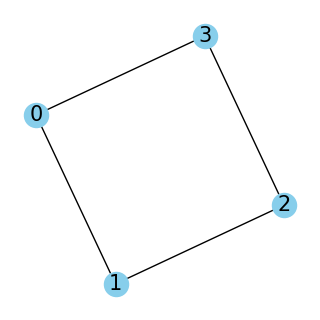

In [ ]:
# Example node features: 4 nodes with 3 features each
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]], dtype=torch.float)
# Example edge index: 4 edges (0->1, 1->2, 2->3, 3->0)
# shape = [2, num_edges]
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)

# Example graph data object
data = Data(x=x, edge_index=edge_index)
G = to_networkx(data, to_undirected=True)
print("is this a Laman graph? {}".format(is_laman_graph(G,2)))
visualize_graph(data)
del x, edge_index, data, G

In [ ]:
from google.colab import drive
import os
if not os.path.isdir('/content/drive/My Drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

Mounted at /content/drive


In [ ]:
import os
filepath = "/content/drive/MyDrive/Colab Notebooks/Laman/"
os.chdir(filepath)
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks/Laman


In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## check Dataset

In [ ]:
all_small_graphs = nx.graph_atlas_g()[3:209]

num_of_vertices = 6
num_of_edges = 2 * num_of_vertices - 3

filtered_graphs = [g for g in all_small_graphs \
                   if g.number_of_nodes() == num_of_vertices and g.number_of_edges() == num_of_edges and nx.number_connected_components(g) == 1]


unique_graphs_6_vertices = []
for graph in filtered_graphs:
    is_isomorphic = False
    for existing_graph in unique_graphs_6_vertices:
        # Check if the current graph is isomorphic to any existing graph
        if nx.is_isomorphic(graph, existing_graph):
            is_isomorphic = True
            break
    if not is_isomorphic:
        unique_graphs_6_vertices.append(graph)

print(f"Number of unique graphs: {len(unique_graphs_6_vertices)}")

laman_graph_6_vertices = [g for g in unique_graphs_6_vertices if is_laman_graph(g,2)]
not_laman_graph_6_vertices = [g for g in unique_graphs_6_vertices if not is_laman_graph(g,2)]

print(f"Found Laman graphs : {len(laman_graph_6_vertices)}")
print(f"Found non-Laman graphs : {len(not_laman_graph_6_vertices)}")

Number of unique graphs: 20
Found Laman graphs : 13
Found non-Laman graphs : 7


Number of graphs with 6 vertices and 9 edges: 20


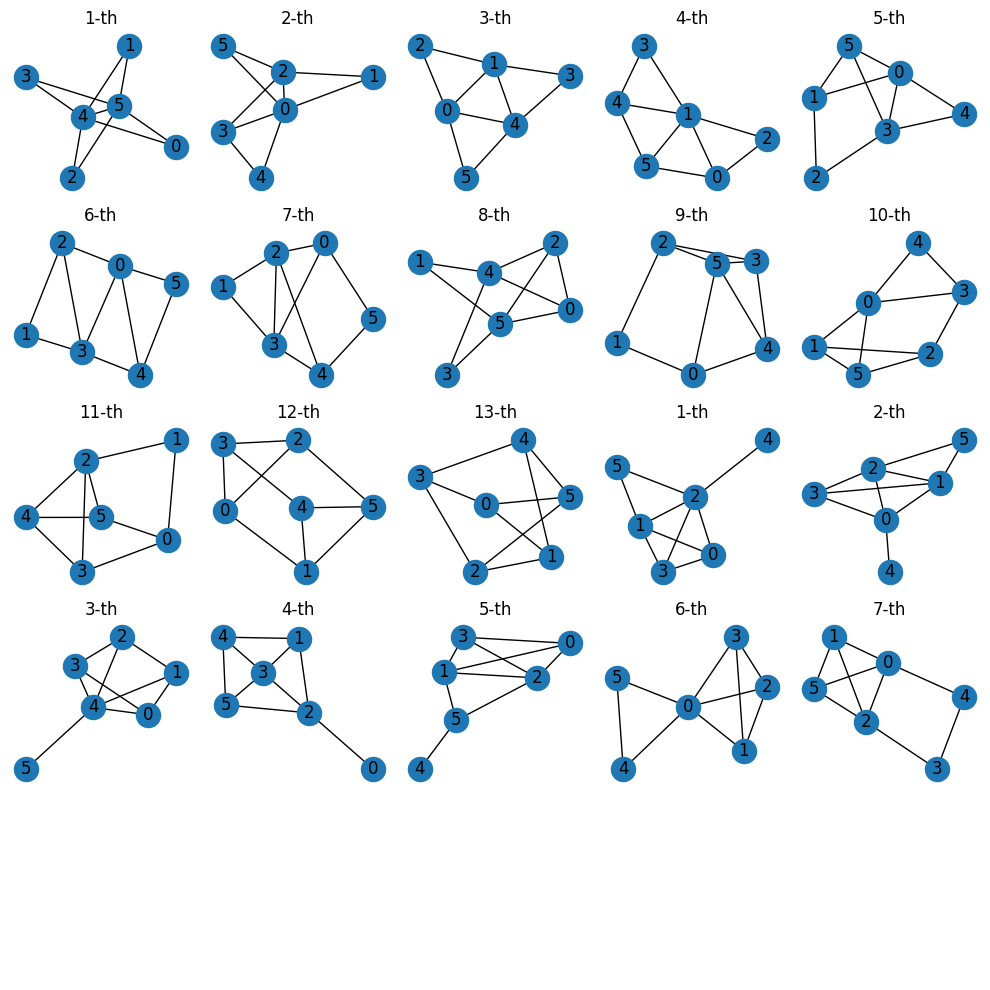

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Adjust figsize as needed
flattened_axes = axes.flatten()

print(f"Number of graphs with {num_of_vertices} vertices and {num_of_edges} edges: {len(filtered_graphs)}")

for i, graph in enumerate(laman_graph_6_vertices):
    subplot = flattened_axes[i]
    subplot.set_title(f"{i+1}-th")
    nx.draw(graph, ax=subplot, with_labels=True)

for i, graph in enumerate(not_laman_graph_6_vertices):
    subplot = flattened_axes[len(laman_graph_6_vertices) + i]
    subplot.set_title(f"{i+1}-th")
    nx.draw(graph, ax=subplot, with_labels=True)

# Fill the remaining subplots with empty spaces
for i in range(len(unique_graphs_6_vertices), 25):
    flattened_axes[i].axis('off')

plt.tight_layout()
plt.show()

## Generate data

In [ ]:
# number of Laman graphs
# 1 1
# 2 1
# 3 1
# 4 1
# 5 3
# 6 13
# 7 70
# 8 608
# 9 7222
# 10 110132
# 11 2039273
# 12 44176717
# https://oeis.org/A273468
# https://oeis.org/A227117

In [ ]:
def generate_graph_data(num_graphs, num_nodes, HT):
    data_list = []
    progress_interval = num_graphs // 10  # Calculate the progress interval for 10% completion

    for i in range(num_graphs):
        G = nx.gnm_random_graph(num_nodes, int((HT * num_nodes - (HT + 1)) / (HT - 1)))
        if nx.is_connected(G):
            degrees = np.array([d for n, d in G.degree()], dtype=np.float32).reshape(-1, 1)
            edge_index = torch.tensor(list(G.edges)).t().contiguous()
            x = torch.tensor(degrees, dtype=torch.float)  # define features as node degrees
            y = torch.tensor([is_laman_graph(G, HT)], dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        # Check for progress at each interval and print a message
        if progress_interval > 1 and (i+1) % progress_interval == 0:
            print(f"Progress: {((i+1) / num_graphs) * 100}% complete ({i+1}/{num_graphs})")

    return data_list

def generate_graph_data_from_list(graphs_list, HT):
    data_list = []
    num_graphs = len(graphs_list)
    progress_interval = num_graphs // 10  # Calculate the progress interval for 10% completion

    for i, G in enumerate(graphs_list):
        if nx.is_connected(G):
            degrees = np.array([d for n, d in G.degree()], dtype=np.float32).reshape(-1, 1)
            edge_index = torch.tensor(list(G.edges)).t().contiguous()
            x = torch.tensor(degrees, dtype=torch.float)  # define features as node degrees
            y = torch.tensor([is_laman_graph(G, HT)], dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        # Check for progress at each interval and print a message
        if progress_interval > 1 and (i+1) % progress_interval == 0:
            print(f"Progress: {((i+1) / num_graphs) * 100}% complete ({i+1}/{num_graphs})")

    return data_list

In [ ]:
from networkx import weisfeiler_lehman_graph_hash as wl_hash

def generate_connected_non_isomorphic_graphs(num_nodes, HT, target_graph_count):
    graph_list = []
    hash_set = set()  # To store WL hashes of graphs
    laman_count = 0
    # while len(graph_list) < target_graph_count:
    for _ in tqdm(range(target_graph_count)):
        # Generate a random graph
        num_edges = int((HT * num_nodes - (HT + 1)) / (HT - 1))
        graph = nx.gnm_random_graph(num_nodes, num_edges)

        # Check if the graph is connected
        if not nx.is_connected(graph):
            continue

        # Use WL hashing to approximate isomorphism check
        g_hash = wl_hash(graph)

        # Only keep the graph if the hash is not seen before (approximate isomorphism avoidance)
        if g_hash not in hash_set:
            graph_list.append(graph)
            hash_set.add(g_hash)
            laman_count += is_laman_graph(graph, HT)

    return graph_list, laman_count

n=3, 12 vertices:
- 100%|██████████| 1000000/1000000 [1:15:59<00:00, 219.34it/s]
- Generated 487596/1000000 connected, including 2290 Laman graphs.

In [ ]:
# Example usage
num_nodes = 12  # Set the number of nodes
HT = 3          # Set the value for HT
num_graphs = 1000000 # Number of graphs to generate
generated_graphs_12, laman_count = generate_connected_non_isomorphic_graphs(num_nodes, HT, num_graphs)

print(f"Generated {len(generated_graphs_12)}/{num_graphs} connected, including {laman_count} Laman graphs.")

100%|██████████| 1000000/1000000 [1:15:59<00:00, 219.34it/s]


Generated 487596/1000000 connected, including 2290 Laman graphs.


In [ ]:
# Example usage
num_nodes = 8  # Set the number of nodes
HT = 3          # Set the value for HT
num_graphs = 500000 # Number of graphs to generate
generated_graphs_10, laman_count = generate_connected_non_isomorphic_graphs(num_nodes, HT, num_graphs)

print(f"Generated {len(generated_graphs_10)}/{num_graphs} connected, including {laman_count} Laman graphs.")

100%|██████████| 500000/500000 [01:07<00:00, 7449.98it/s]

Generated 476/500000 connected, including 13 Laman graphs.


In [ ]:
def are_graphs_non_isomorphic(graph_list):
    # Compare each pair of graphs
    for i in range(len(graph_list)):
        for j in range(i + 1, len(graph_list)):
            if nx.is_isomorphic(graph_list[i], graph_list[j]):
                return False  # Found at least one pair that is isomorphic
    return True

are_graphs_non_isomorphic(generated_graphs)

True

In [ ]:
import pickle
# with open('graphs_8_vertices_HT3.pkl', 'wb') as f:
#     pickle.dump(generated_graphs_10, f)

# with open('graphs_12_vertices_HT3.pkl', 'wb') as f:
#     pickle.dump(generated_graphs_12, f)

In [ ]:
import pickle
# with open('graphs_10_vertices.pkl', 'wb') as f:
#     pickle.dump(generated_graphs, f)

with open('graphs_8_vertices_HT3.pkl', 'rb') as f:
    generated_graphs = pickle.load(f)

In [ ]:
##directly generate graph data randomly.
# HT = 2
# num_graphs = 200  # Number of graphs to generate
# num_nodes = 7  # Number of nodes per graph

# # Generate graph data
# # note the length of dataset is not num_graphs, since non-connected graphs are discarded.
# dataset = generate_graph_data(num_graphs, num_nodes, HT)

In [ ]:
HT = 3
with open('graphs_10_vertices_HT3.pkl', 'rb') as f:
    generated_graphs = pickle.load(f)
dataset = generate_graph_data_from_list(generated_graphs, HT)

Progress: 9.998972356386805% complete (1946/19462)
Progress: 19.99794471277361% complete (3892/19462)
Progress: 29.996917069160418% complete (5838/19462)
Progress: 39.99588942554722% complete (7784/19462)
Progress: 49.99486178193403% complete (9730/19462)
Progress: 59.993834138320835% complete (11676/19462)
Progress: 69.99280649470764% complete (13622/19462)
Progress: 79.99177885109444% complete (15568/19462)
Progress: 89.99075120748124% complete (17514/19462)
Progress: 99.98972356386805% complete (19460/19462)


In [ ]:
# [dataset[i].y.item() for i in range(len(dataset))]

In [ ]:
from collections import Counter
Counter([dataset[i].y.item() for i in range(len(dataset))])

Counter({0: 19273, 1: 189})

is this a Laman graph? False


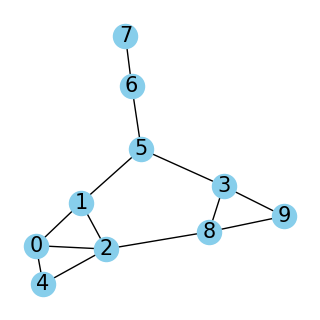

the number of vertices = 10
the number of edges = 13


In [ ]:
data = dataset[1] # 0,9
G = to_networkx(data, to_undirected=True)
print("is this a Laman graph? {}".format(is_laman_graph(G,HT)))
visualize_graph(data)


num_of_vertices = data.x.shape[0]
num_of_edges = data.edge_index.shape[1]
print(f"the number of vertices = {num_of_vertices}")
print(f"the number of edges = {num_of_edges}")

In [ ]:
torch.save(dataset, 'dataset/laman_graphs_dataset_10nodes_HT3.pt')

## Convolutional Neural Network

### preprocessing the data

In [ ]:
# Load the dataset from the file
dataset = torch.load('dataset/laman_graphs_dataset_12nodes_HT3.pt', weights_only=False)

In [ ]:
def add_features_to_graphs(dataset):
    for data in dataset:
        # Convert PyG data object to NetworkX graph
        # Calculate the clustering coefficient for each node
        G = to_networkx(data, to_undirected=True)
        clustering = nx.clustering(G)  # Returns a dictionary node_id -> clustering coefficient
        clustering_coeff = torch.tensor([clustering[i] for i in range(data.num_nodes)], dtype=torch.float)

        # Calculate node degrees
        data.edge_index = to_undirected(data.edge_index)
        deg = degree(data.edge_index[0], data.num_nodes)  # Tensor of degrees
        data.x = torch.stack([deg, clustering_coeff], dim=1)


# Example usage:
# Assuming 'dataset' is a list of PyTorch Geometric Data objects
add_features_to_graphs(dataset)

[Clustering Coefficient ](https://link.springer.com/referenceworkentry/10.1007/978-1-4419-9863-7_1239).  See downloaded [pdf](/content/drive/MyDrive/Colab Notebooks/Laman/references/clustering coefficients.pdf)

is this a Laman graph? False


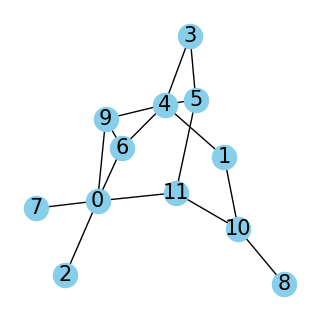

the number of vertices = 12
the number of edges = 16


In [ ]:
data = dataset[3]
G = to_networkx(data, to_undirected=True)
print("is this a Laman graph? {}".format(is_laman_graph(G, 2)))
visualize_graph(data)

num_of_vertices = data.x.shape[0]
num_of_edges = data.edge_index.shape[1]
if is_undirected(data.edge_index):
    num_of_edges = num_of_edges // 2
print(f"the number of vertices = {num_of_vertices}")
print(f"the number of edges = {num_of_edges}")

In [ ]:
# Combine all nodes' features into a single tensor to compute the mean and std
all_features = torch.cat([data.x for data in dataset], dim=0)
mean = all_features.mean(dim=0) # the first element is num_of_edges/num_of_vertices
std = all_features.std(dim=0)

In [ ]:
# Avoid division by zero for std
std[std == 0] = 1 # std is a 1d tensor of size 2

# Normalize the features of each graph
for data in dataset:
    data.x = (data.x - mean) / std
# Now `dataset` is a list of Data objects with normalized features
# Save the normalized dataset
torch.save(dataset, 'dataset/laman_graphs_dataset_12nodes_HT3_normalized.pt')

### load the data

In [ ]:
dataset = torch.load('dataset/laman_graphs_dataset_12nodes_HT3_normalized.pt', weights_only=False)

labels = [graph.y.item() for graph in dataset]

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=labels, random_state=42)

# Create training and testing datasets using indices
train_dataset = [dataset[i] for i in train_indices]
test_dataset = [dataset[i] for i in test_indices]

In [ ]:
original_proportions = Counter(labels)
train_labels = [graph.y.item() for graph in train_dataset]
test_labels = [graph.y.item() for graph in test_dataset]
train_proportions = Counter(train_labels)
test_proportions = Counter(test_labels)

print("Original Proportions:")
print(original_proportions)
print("Training Proportions:")
print(train_proportions)
print("Testing Proportions:")
print(test_proportions)

Original Proportions:
Counter({0: 485306, 1: 2290})
Training Proportions:
Counter({0: 388244, 1: 1832})
Testing Proportions:
Counter({0: 97062, 1: 458})


In [ ]:
# Create a list to store graph information
graph_info = []

# Populate the list with data about each graph
for data in dataset:
    graph_info.append({
        'is_laman': data.y.item(),
        'num_nodes': data.num_nodes,
        'num_edges': data.num_edges
    })

# Convert the list to a DataFrame
df = pd.DataFrame(graph_info)

# Now you can use Pandas to analyze the dataset
print(df.describe())  # Get descriptive statistics for the dataset
print(df['is_laman'].value_counts())  # Count occurrences of Laman vs. non-Laman

            is_laman  num_nodes  num_edges
count  487596.000000   487596.0   487596.0
mean        0.004697       12.0       32.0
std         0.068370        0.0        0.0
min         0.000000       12.0       32.0
25%         0.000000       12.0       32.0
50%         0.000000       12.0       32.0
75%         0.000000       12.0       32.0
max         1.000000       12.0       32.0
is_laman
0    485306
1      2290
Name: count, dtype: int64


### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
dropout_rate = 0.11949250418763864
lr = 0.0039397884627024714
weight_decay = 2.8461801243807926e-05

batch_size = 128

num_units1 = 43
num_units2 = 34
num_units3 = 57

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, num_units1, num_units2, num_units3, dropout_rate):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(2, num_units1)  # 1 feature per input node
        self.conv2 = GCNConv(num_units1, num_units2)
        self.conv3 = GCNConv(num_units2, num_units3)
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.dropout3 = torch.nn.Dropout(dropout_rate)
        self.fc = torch.nn.Linear(num_units3, 2)  # 2 classes: Laman or not Laman

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout3(x)
        x = global_max_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


def collate_fn(batch):
    return torch_geometric.data.Batch.from_data_list(batch)

# Assuming train_dataset is a list of torch_geometric.data.Data objects
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=True,
                          collate_fn=collate_fn, generator=torch.Generator().manual_seed(42),)
test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          pin_memory=True,
                          collate_fn=collate_fn,generator=torch.Generator().manual_seed(42), )

In [ ]:
# Set the random seed for reproducibility
set_seed(42)

# Initialize the model, optimizer, scheduler, and criterion
model = GNN(num_units1, num_units2, num_units3, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

print(summary(model))

# DataFrames to store metrics
columns = ['Epoch', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
train_metrics_df = pd.DataFrame(columns=columns)
test_metrics_df = pd.DataFrame(columns=columns)

num_epochs = 31
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    y_true = []
    y_pred = []
    y_prob = []

    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = output.argmax(dim=1)
        y_true.append(data.y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())
        y_prob.append(F.softmax(output, dim=1)[:, 1].cpu().detach().numpy())  # Probabilities for the positive class

    if epoch % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        y_prob = np.concatenate(y_prob)

        train_metrics = pd.DataFrame({
            'Epoch': [epoch],
            'Loss': [avg_loss],
            'Accuracy': [accuracy_score(y_true, y_pred)],
            'Precision': [precision_score(y_true, y_pred, average='binary')],
            'Recall': [recall_score(y_true, y_pred, average='binary')],
            'F1-Score': [f1_score(y_true, y_pred, average='binary')],
            'AUC-ROC': [roc_auc_score(y_true, y_prob)]
        })
        if train_metrics_df.empty:
            train_metrics_df = train_metrics
        else:
            train_metrics_df = pd.concat([train_metrics_df, train_metrics], ignore_index=True)

        # Test set evaluation
        model.eval()
        y_true_test = []
        y_pred_test = []
        y_prob_test = []

        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                y_true_test.append(data.y.cpu().numpy())
                y_pred_test.append(pred.cpu().numpy())
                y_prob_test.append(F.softmax(output, dim=1)[:, 1].cpu().detach().numpy())

        y_true_test = np.concatenate(y_true_test)
        y_pred_test = np.concatenate(y_pred_test)
        y_prob_test = np.concatenate(y_prob_test)

        test_metrics = pd.DataFrame({
            'Epoch': [epoch],
            'Loss': [avg_loss],
            'Accuracy': [accuracy_score(y_true_test, y_pred_test)],
            'Precision': [precision_score(y_true_test, y_pred_test)],
            'Recall': [recall_score(y_true_test, y_pred_test)],
            'F1-Score': [f1_score(y_true_test, y_pred_test)],
            'AUC-ROC': [roc_auc_score(y_true_test, y_prob_test)]
        })
        if test_metrics_df.empty:
            test_metrics_df = test_metrics
        else:
            test_metrics_df = pd.concat([test_metrics_df, test_metrics], ignore_index=True)

Layer (type:depth-idx)                   Param #
GNN                                      --
├─GCNConv: 1-1                           43
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       86
├─GCNConv: 1-2                           34
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       1,462
├─GCNConv: 1-3                           57
│    └─SumAggregation: 2-5               --
│    └─Linear: 2-6                       1,938
├─Dropout: 1-4                           --
├─Dropout: 1-5                           --
├─Dropout: 1-6                           --
├─Linear: 1-7                            116
Total params: 3,736
Trainable params: 3,736
Non-trainable params: 0


100%|██████████| 31/31 [16:01<00:00, 31.02s/it]


## evaluations

In [ ]:
test_metrics_df

,Epoch,Loss,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,0,0.009017,0.997836,0.700813,0.941048,0.803355,0.999438
1,10,0.002930,0.999282,0.888000,0.969432,0.926931,0.999857
2,20,0.002506,0.999149,0.853107,0.989083,0.916077,0.999868
3,30,0.002547,0.999303,0.883858,0.980349,0.929607,0.999867


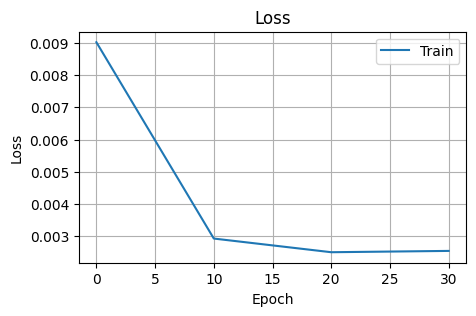

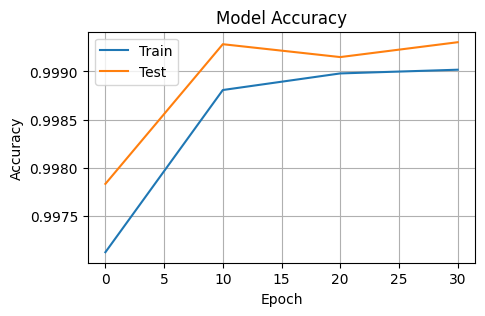

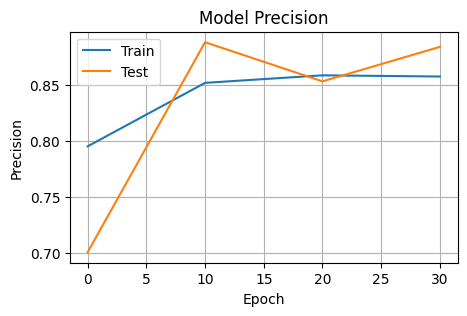

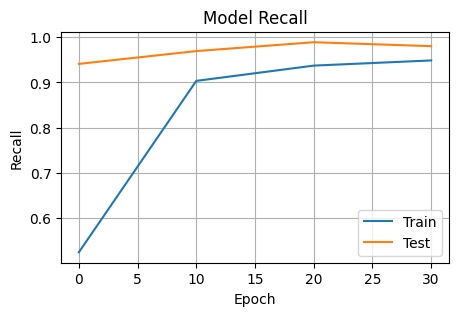

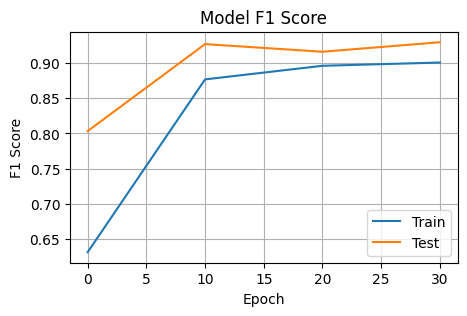

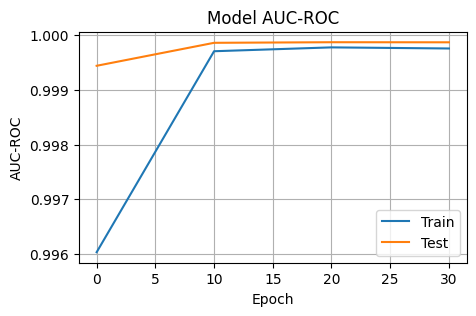

In [ ]:
# Function to plot metrics
def plot_metrics(train_df, test_df, metric_name, title, ylabel):
    plt.figure(figsize=(5, 3))
    if len(train_df) > 0:
        plt.plot(train_df['Epoch'], train_df[metric_name], label='Train')
    if len(test_df) > 0:
        plt.plot(test_df['Epoch'], test_df[metric_name], label='Test')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting each metric
plot_metrics(train_metrics_df, [], 'Loss', 'Loss', 'Loss')
plot_metrics(train_metrics_df, test_metrics_df, 'Accuracy', 'Model Accuracy', 'Accuracy')
plot_metrics(train_metrics_df, test_metrics_df, 'Precision', 'Model Precision', 'Precision')
plot_metrics(train_metrics_df, test_metrics_df, 'Recall', 'Model Recall', 'Recall')
plot_metrics(train_metrics_df, test_metrics_df, 'F1-Score', 'Model F1 Score', 'F1 Score')
plot_metrics(train_metrics_df, test_metrics_df, 'AUC-ROC', 'Model AUC-ROC', 'AUC-ROC')

Test: Accuracy: 0.9993, Precision: 0.8839, Recall: 0.9803, F1-Score: 0.9296
Confusion Matrix:


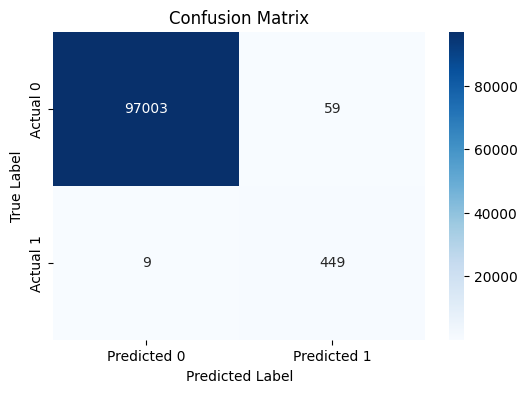

In [ ]:
model.eval()
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():  # No gradient calculation for testing
    for data in test_loader:
        data = data.to(device)
        output = model(data)  # Get model predictions (logits)

        # Get predicted class labels
        pred = output.argmax(dim=1)  # Use argmax to get the predicted class (binary 0/1)
        y_true.append(data.y.cpu().numpy())  # Store true labels
        y_pred.append(pred.cpu().numpy())    # Store predicted labels
        y_prob.append(F.softmax(output, dim=1)[:, 1].cpu().numpy())  # Store predicted probabilities for class 1

# Convert to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_prob)

# Output results
print(f"Test: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with labels
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The graph is not a Laman graph.


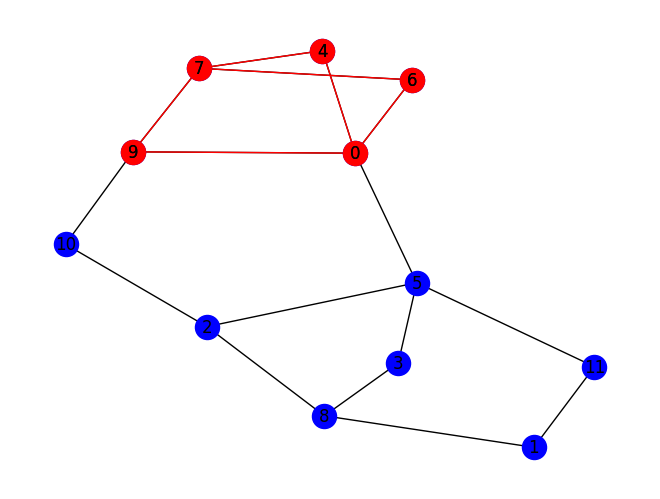

The graph is not a Laman graph.


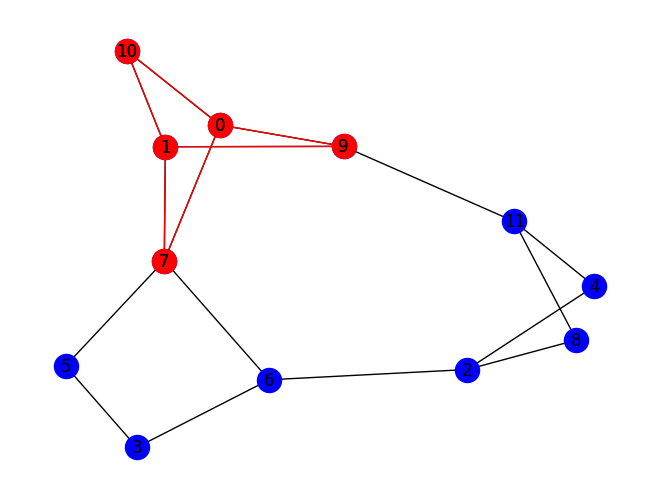

The graph is not a Laman graph.


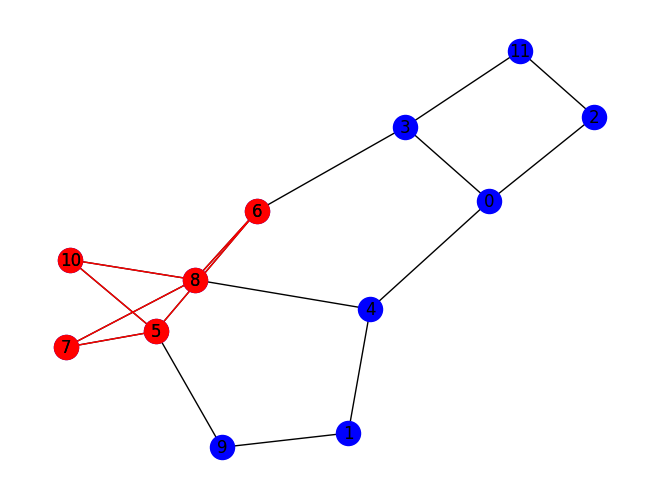

The graph is not a Laman graph.


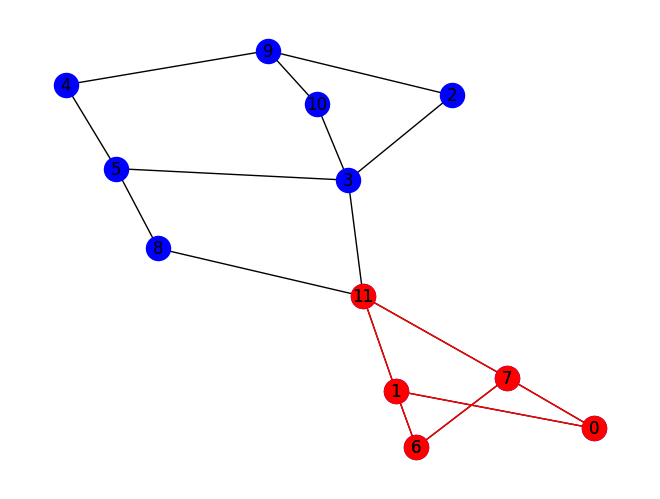

The graph is a Laman graph.
The graph is not a Laman graph.


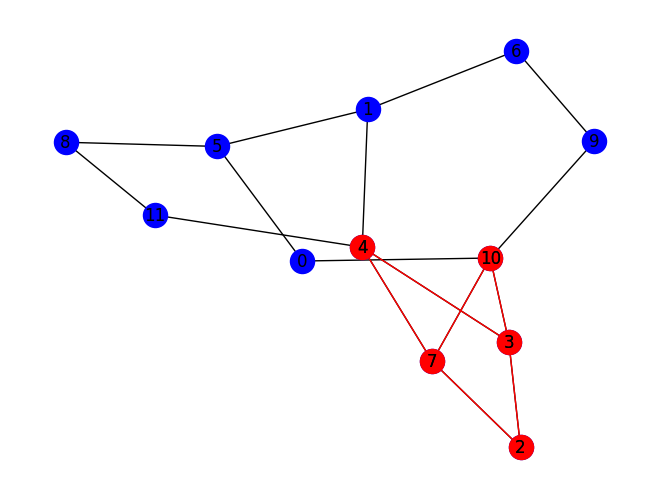

The graph is not a Laman graph.


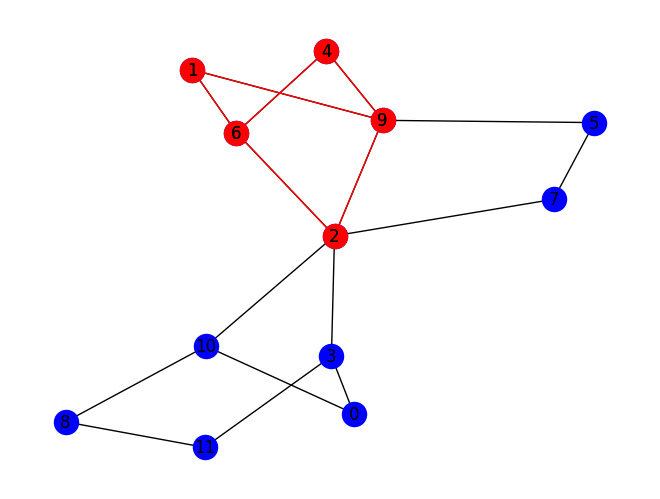

The graph is not a Laman graph.


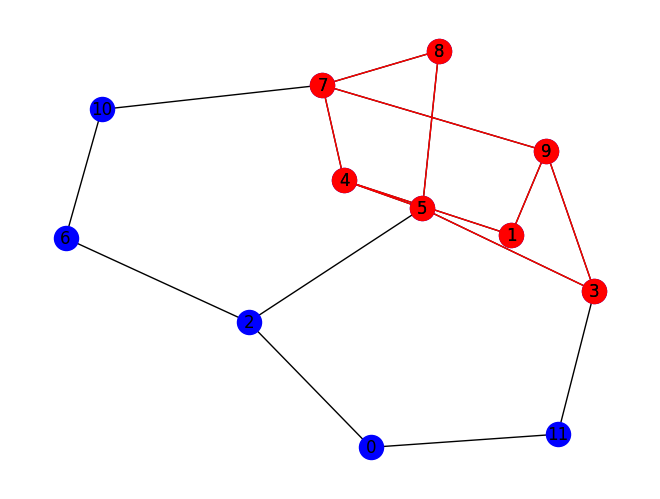

The graph is not a Laman graph.


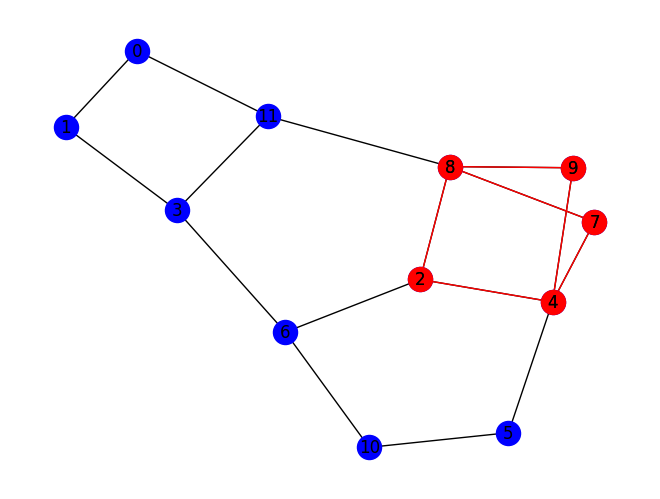

The graph is a Laman graph.
The graph is not a Laman graph.


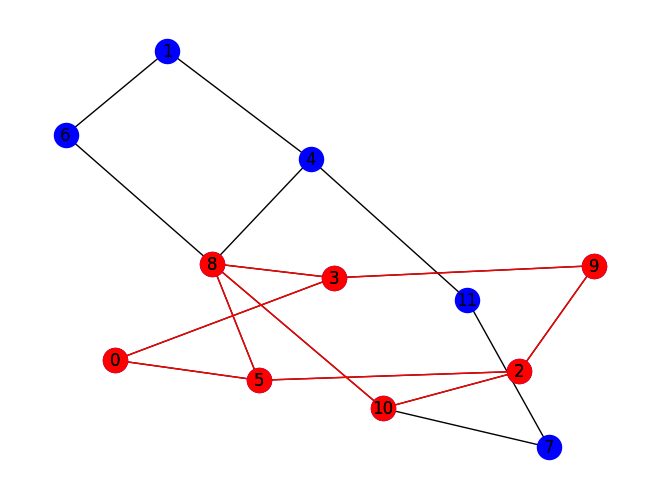

The graph is not a Laman graph.


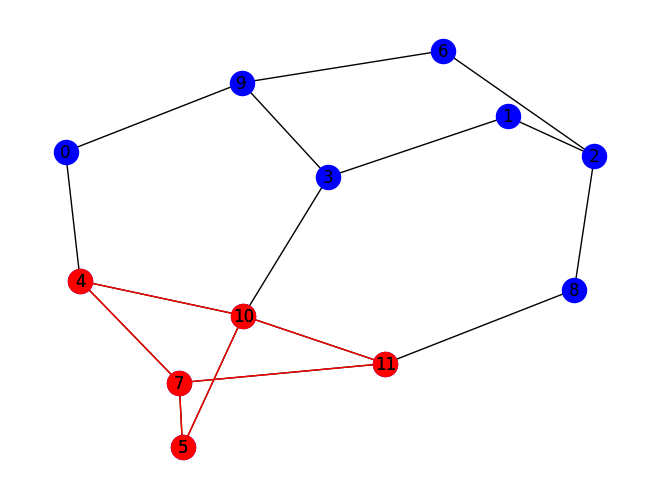

The graph is not a Laman graph.


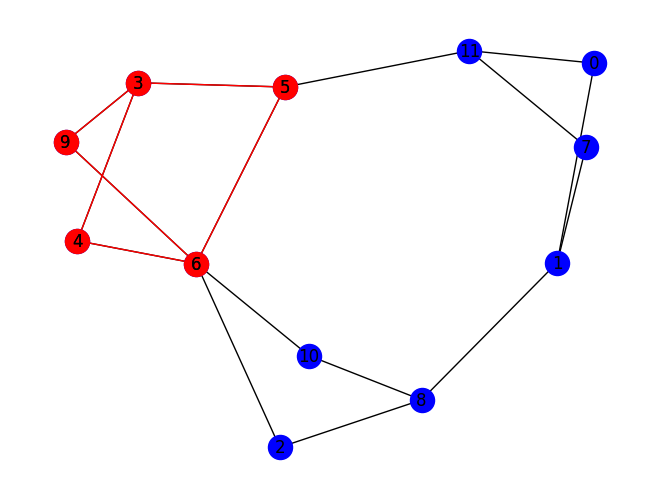

The graph is not a Laman graph.


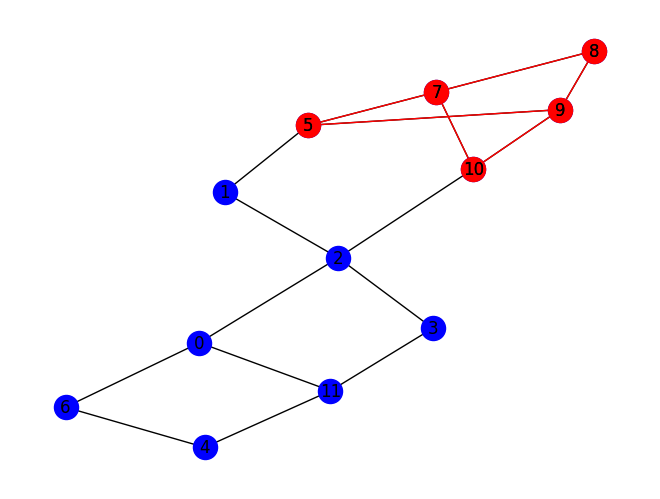

The graph is not a Laman graph.


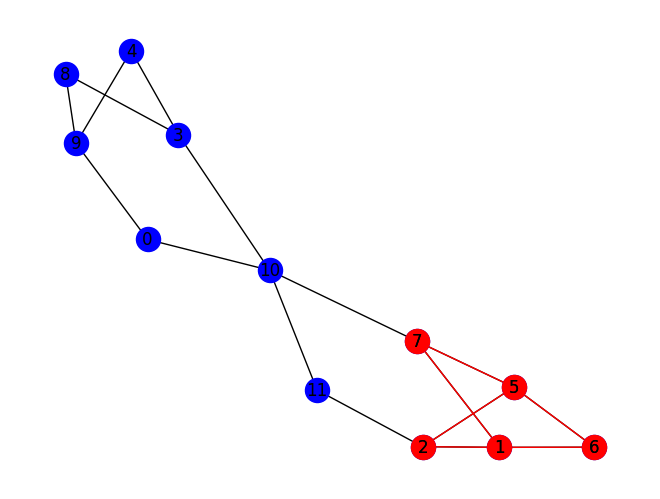

The graph is a Laman graph.


In [ ]:
model.eval()  # Set the model to evaluation mode
count = 0
with torch.no_grad():  # Disable gradient computation
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        correct = pred.eq(data.y.view_as(pred))  # Check if predictions are correct

        # Convert data to NetworkX graph for visualization (assuming the dataset allows it)
        for i in range(len(data.y)):

            if correct[i].item():
                # print("skipped correct prediction")
                continue

            graph = to_networkx(data[i], to_undirected=True, remove_self_loops=True)
            label = data.y[i].item()
            prediction = pred[i].item()
            is_correct = 'Correct' if correct[i].item() else 'Incorrect'

            # # Plot the graph
            # plt.figure(figsize=(4, 4))
            # nx.draw(graph, node_color='lightblue', edge_color='gray', node_size=50)
            # plt.title(f'Graph {i+1}: Laman - {label}, Prediction - {prediction} ({is_correct})')
            # plt.show()

            HT = 3  # Example value for HT
            result, problematic_subgraph = is_laman_graph_with_failures(graph, HT)

            if result:
                print("The graph is a Laman graph.")
            else:
                print("The graph is not a Laman graph.")
                if problematic_subgraph:
                    # Plotting the graph with problematic subgraph highlighted
                    pos = nx.spring_layout(graph)  # Position nodes for better visualization
                    nx.draw(graph, pos, with_labels=True, node_color='blue')  # Draw the main graph
                    nx.draw(problematic_subgraph, pos, with_labels=True, node_color='red', edge_color='red')  # Highlight problematic subgraph
                    plt.show()


            count += 1
            if count > 15:
                break

        if count > 15:
            break